# Time variant filtering

Time variant filtering

In [17]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

class TimeVariantFiltering(torch_nn.Module):
    """ TimeVariantFiltering
    Given sequences of filter coefficients and a signal, do filtering
    
    Initialization: TimeVariantFiltering()
    Forward: output = forward(self, signal, filter_coef)
    
        Filter_coefs: (batchsize, signal_length, filter_order = K)
        Signal:       (batchsize, signal_length, dim)
        
        Output:       (batchsize, signal_length, dim)
        
    For d in [0 dim]:
        For n in [0, sequence_length):
            output(0, n, d) = \sum_{k=1}^{K} signal(0, n-k, d)*coef(0, n, k)
        
        
    Suppose signal [x_1, ..., x_N], filter [a_1, ..., a_K]
    output         [y_1, y_2, y_3, ..., y_N, *, * ... *]
            = a_1 * [x_1, x_2, x_3, ..., x_N,   0, ...,   0]
            + a_2 * [  0, x_1, x_2, x_3, ..., x_N,   0, ...,  0]
            + a_3 * [  0,   0, x_1, x_2, x_3, ..., x_N, 0, ...,  0]
        
    """
    def __init__(self):
        super(TimeVariantFiltering, self).__init__()
    
    def forward(self, signal, f_coef):
        """ 
        """
        # signal length
        signal_l = signal.shape[1]
        # order of the time varint filter
        order_k = f_coef.shape[-1]
        
        # pad to signal (batchsize, signal_length + filter_order-1, dim)
        padded_signal = torch_nn_func.pad(signal, (0, 0, 0, order_k - 1))
        
        output = torch.zeros_like(signal)
        # roll and weighted sum, only take [0:signal_length]
        for k in range(order_k):
            output += torch.roll(padded_signal, k, dims=1)[:, 0:signal_l, :] \
                      * f_coef[:, :, k:k+1] 
        return output
    

Text(0.5, 0, 'dimension of filter')

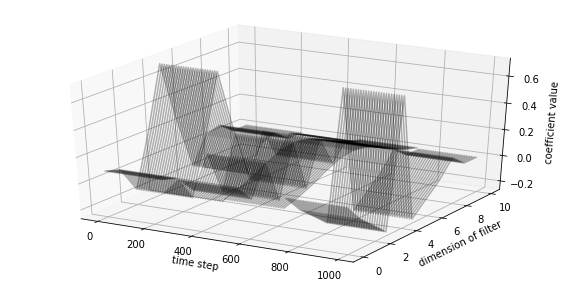

In [40]:
from scipy import signal as sci_signal
import scipy.fft
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 5)


# Prepare input signal
signal_length = 1000
signal_dim = 2
batch_size = 2

signal_input = torch.randn(batch_size, signal_length, signal_dim, requires_grad = False)


# Prepare a time-variant filter based on the following filter coefficients
# The filter coefficients should be in shape [batch_size, signal_length, filter_order]
# In this example, different batches use the same filter coefs 
lp_v = torch.tensor([0.08538414199291068, 0.04920229475534168, -0.1470178606967731, 0.24737764593887432, 0.7103067853166558, 0.24737764593887432, -0.1470178606967731, 0.04920229475534168, 0.08538414199291068])
lp_u = torch.tensor([0.00936455546502, 0.0416254862901, 0.0878313219556, 0.146086321198, 0.192602581136, 0.211221591449, 0.192602581136, 0.146086321198, 0.0878313219556, 0.0416254862901, 0.00936455546502])
hp_v = torch.tensor([-0.00936455546502148, 0.04162548629009957, -0.08783132195564508, 0.1460863211980122, -0.19260258113649556,  0.21122159144894015, -0.19260258113649556, 0.1460863211980122, -0.08783132195564508, 0.04162548629009957, -0.00936455546502148])
hp_u = torch.tensor([0.0853841419929, -0.0492022947553, -0.147017860697, -0.247377645939, 0.710306785317, -0.247377645939, -0.147017860697, -0.0492022947553, 0.0853841419929])

# initialize buffer
tv_filter_coefs = torch.zeros(batch_size, signal_length, max([len(lp_v), len(lp_u), len(hp_v), len(hp_u)]))
# assume the time-variant filter changes very signal_length / 4 time steps
tv_filter_coefs[:, signal_length//4*0:signal_length//4*1, 0:len(lp_v)] = lp_v
tv_filter_coefs[:, signal_length//4*1:signal_length//4*2, 0:len(hp_v)] = hp_v
tv_filter_coefs[:, signal_length//4*2:signal_length//4*3, 0:len(lp_u)] = lp_u
tv_filter_coefs[:, signal_length//4*3:, 0:len(hp_u)] = hp_u

fig = plt.figure()
ax = fig.gca(projection='3d')
for idx in range(signal_length)[::10]:
    y = np.arange(tv_filter_coefs.shape[-1])
    x = np.ones([tv_filter_coefs.shape[-1]]) * idx
    z = tv_filter_coefs[0, idx, :]
    ax.plot(x, y, z, 'k', alpha=0.3)
ax.set_xlabel('time step')
ax.set_zlabel('coefficient value')
ax.set_ylabel('dimension of filter')

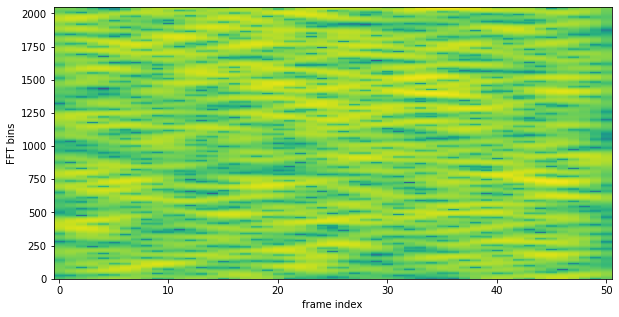

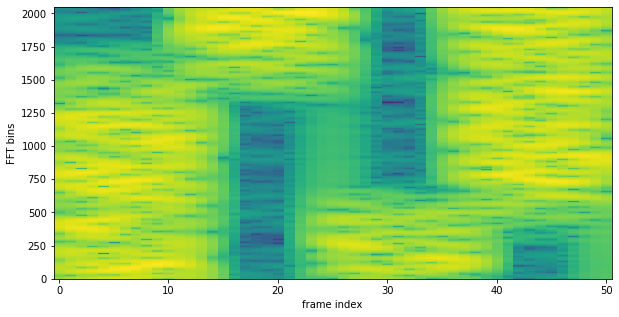

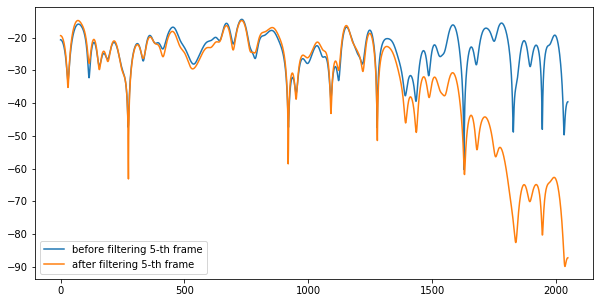

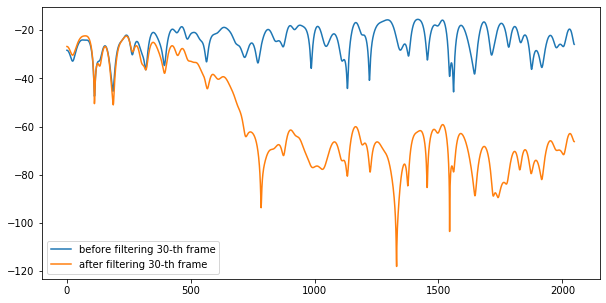

In [39]:
# initialize. the TimeVariantFiltering Layer and try filtering
# do filering
tv_layer = TimeVariantFiltering()
signal_output = tv_layer(signal_input, tv_filter_coefs)


# Plot 
# let's try to plot the spectrogram
# let's analysis only one signal
import tool_lib
signal_in_examine = signal_input[0, :, 0]
signal_out_examine = signal_output[0, :, 0]

spec_in_examine = tool_lib.spec_amplitude(signal_in_examine, frame_length=200, frame_shift=20)
spec_out_examine = tool_lib.spec_amplitude(signal_out_examine, frame_length=200, frame_shift=20)

plt.figure()
plt.imshow(spec_in_examine, aspect='auto', origin='lower')
plt.xlabel('frame index')
plt.ylabel('FFT bins')
plt.figure()
plt.imshow(spec_out_examine, aspect='auto', origin='lower')
plt.xlabel('frame index')
plt.ylabel('FFT bins')

plt.figure()
frame_idx = 5
plt.plot(spec_in_examine[:, frame_idx])
plt.plot(spec_out_examine[:, frame_idx])
plt.legend(["before filtering %d-th frame" % (frame_idx), "after filtering %d-th frame" % (frame_idx)])

plt.figure()
frame_idx = 30
plt.plot(spec_in_examine[:, frame_idx])
plt.plot(spec_out_examine[:, frame_idx])
plt.legend(["before filtering %d-th frame" % (frame_idx), "after filtering %d-th frame" % (frame_idx)])


(2049, 51)